### **Importing the libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import log2, floor

## **1. Build a decision-tree classifier by randomly splitting the dataset as 80/20 split. Use the impurity measures- 1) gini index and 2) information gain. Analyze the impact of using individual impurity measures on the prediction. Do not use package for building the tree and implement this part on your own.**

## **Decision Tree**

### **Defining the structure of the Decision Tree node**



In [ ]:
class TreeNode():
    def __init__(self, is_leaf, attribute=None, split_value=None, left=None, right=None, target_class=None):
        # node attribute to differentiate between internal and leaf node
        self.is_leaf = is_leaf

        # atrributes for internal/decision node
        self.attribute = attribute
        self.split_value = split_value
        self.left = left
        self.right = right

        # attribute for stroring class in leaf node
        self.target_class = target_class

### **Decision Tree**

In [ ]:
class DecisionTree():
    def __init__(self, impurity_measure, max_depth=10**12):
        self.root = None
        self.impurity_measure = impurity_measure.lower()
        self.max_depth = max_depth
    
    def build_tree(self, data, curr_depth):
        target = data.columns[-1]
        classes = data[target].unique()

        if len(classes) == 1:                       # if all data are of same class create a leaf node with the majority class
            majority_class = classes[0]
            return TreeNode(is_leaf=True, target_class=majority_class)
        
        if curr_depth == self.max_depth:                # if maximum depth reached create a leaf node with the majority class
            majority = 0
            majority_class = None

            for c in classes:
                count = len(data[data[target] == c])
                if count > majority:
                    majority = count
                    majority_class = c

            return TreeNode(is_leaf=True, target_class=majority_class)
    
        m = data.shape[1]

        best_gain = float('-inf')
        best_attribute = None
        best_threshold = 0
        
        for i in range(m-1):
            col = data.columns[i]

            if data[col].nunique() == 1:            # if there is only 1 unique element in the column skip it
                continue
            
            gain, threshold = self.information_gain(data, col)
            if gain > best_gain:
                best_gain = gain
                best_attribute = col
                best_threshold = threshold
        
        if best_attribute is not None:
            split_value = best_threshold
            left_data = data[data[best_attribute] <= best_threshold]
            right_data = data[data[best_attribute] > best_threshold]

        if best_attribute is None or len(left_data) == 0 or len(right_data) == 0:  # if no best attribute is found or data on left or right side has zero(0) instances then create leaf node
            target = data.columns[-1]
            classes = data[target].unique()
            majority = 0
            majority_class = None

            for c in classes:
                count = len(data[data[target] == c])
                if count > majority:
                    majority = count
                    majority_class = c

            return TreeNode(is_leaf=True, target_class=majority_class)
            
        left = self.build_tree(left_data, curr_depth+1)         # recursively build the left subtree
        right = self.build_tree(right_data, curr_depth+1)       # recursively build the right subtree
            
        return TreeNode(is_leaf=False, attribute=best_attribute, split_value=split_value, left=left, right=right)   # create a new decision node and return it
    
    def entropy(self, data):        # function to calculate the entropy impurity measure of a given data
        res = 0

        target = data.columns[-1]
        classes = data[target].unique()
        
        for c in classes:
            count = len(data[data[target] == c])
            if count != 0:
                res -= (count/len(data))*log2(count/len(data))
            
        return res

    def gini_index(self, data):     # function to calculate the gini index impurity measure of a given data
        res = 0

        target = data.columns[-1]
        classes = data[target].unique()

        for c in classes:
            count = len(data[data[target] == c])
            res += (count/len(data))**2
            
        return 1-res
  
    def information_gain(self, data, col):      # # function to calculate the information gain and best threshold split value at a node if the data is split on a particular attribute
        if self.impurity_measure == "entropy":
            data_impurity = self.entropy(data)
        else:
            data_impurity = self.gini_index(data)
            
        best_gain = float('-inf')
        best_threshold = 0

        values = data[col].unique()
        values.sort()

        for i in range(len(values) - 1):
            threshold = (values[i] + values[i+1])//2

            gain = data_impurity

            left_data = data[data[col] <= threshold]
            right_data = data[data[col] > threshold]

            if self.impurity_measure == "entropy":
                gain -= (len(left_data)/len(data))*self.entropy(left_data)
                gain -= (len(right_data)/len(data))*self.entropy(right_data)
            else:
                gain -= (len(left_data)/len(data))*self.gini_index(left_data)
                gain -= (len(right_data)/len(data))*self.gini_index(right_data)

            if gain > best_gain:
                best_gain = gain
                best_threshold = threshold

        return (best_gain, best_threshold)
  
    def fit(self, X, y):                    # this function invokes the build tree method to build the tree on the given training data
        data = pd.concat([X, y], axis=1)
        self.root = self.build_tree(data, 0)

    def tree_depth(self, root=None):        # function to find the depth of the tree
        if root is None:
            root = self.root

        if root.is_leaf:
            return 0

        return 1 + max(self.tree_depth(root.left), self.tree_depth(root.right))

    def tree_nodes(self, root=None):        # fucntion to find the height of the tree
        if root is None:
            root = self.root

        if root.is_leaf:
            return 1

        return 1 + self.tree_nodes(root.left) + self.tree_nodes(root.right)
  
    def get_class(self, root, X):           # recursively find the class a given data point belongs to in the built decision tree
        if root.is_leaf:
            return root.target_class

        if X[root.attribute] <= root.split_value:
            return self.get_class(root.left, X)
        return self.get_class(root.right, X)
    
    def predict(self, X):               # function to predict which class a given data point belongs to
        return self.get_class(self.root, X)

### **Function to read the dataset**

In [ ]:
def read_data():
    '''
        reads the dataset and returns a dataframe containing the required columns and after dichotomising the required column
    '''
    cols = ['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks']  # required columns in dataset
    skip = [85, 317, 149, 175]                                      # duplicate rows to skip
    useful_cols = 6                                                 # only the first 6 columns are useful

    df = pd.read_csv('bupa.data', names=cols, skiprows=skip, usecols=[i for i in range(useful_cols)])

    # Performing Dichotomisation on the target label
    median = df[df.columns[-1]].median()                    # Dichotomising using the median of the target column
    df.loc[(df[df.columns[-1]] < median), cols[-1]] = 0     # Class 0
    df.loc[(df[df.columns[-1]] >= median), cols[-1]] = 1    # Class 1
    df = df.astype(int)
    
    return df

data = read_data()

### **Splitting the data into train and test**


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=19, test_size=0.2)

X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

### **Creating the Decision Tree with Entropy, training and testing it**

In [ ]:
model_entropy = DecisionTree(impurity_measure="entropy")
model_entropy.fit(X_train, y_train)

correct = 0

for i in range(len(X_train)):
  prediction = model_entropy.predict(X_train.iloc[i])
  if prediction == y_train.iloc[i]:
    correct += 1

print("Train Accuracy of Decision Tree with Entropy:", (correct/len(X_train))*100)

correct = 0

for i in range(len(X_test)):
  prediction = model_entropy.predict(X_test.iloc[i])
  if prediction == y_test.iloc[i]:
    correct += 1

print("Test Accuracy of Decision Tree with Entropy:", (correct/len(X_test))*100)

Train Accuracy of Decision Tree with Entropy: 100.0
Test Accuracy of Decision Tree with Entropy: 55.072463768115945


### **Creating the Decision Tree with Gini Index, training and testing it**

In [ ]:
model_gini_index = DecisionTree(impurity_measure="gini_index")
model_gini_index.fit(X_train, y_train)

correct = 0

for i in range(len(X_train)):
  prediction = model_gini_index.predict(X_train.iloc[i])
  if prediction == y_train.iloc[i]:
    correct += 1

print("Train Accuracy of Decision Tree with Gini Index:", (correct/len(X_train))*100)

correct = 0

for i in range(len(X_test)):
  prediction = model_gini_index.predict(X_test.iloc[i])
  if prediction == y_test.iloc[i]:
    correct += 1

print("Test Accuracy of Decision Tree with Gini Index:", (correct/len(X_test))*100)

Train Accuracy of Decision Tree with Gini Index: 100.0
Test Accuracy of Decision Tree with Gini Index: 57.971014492753625


## **2. Provide the accuracy by averaging over 10 random 80/20 splits. Consider that particular tree which provides the best test accuracy as the desired one.**

### **Averaging the test accuracy over 10 random 80/20 splits for both the decision trees**

In [ ]:
def average_test_accuracy(data, runs):
    total_accuracy_entropy = 0
    total_accuracy_gini_index = 0

    for i in range(runs):
        train, test = train_test_split(data, test_size=0.2)

        X_train = train.iloc[:, :-1]
        y_train = train.iloc[:, -1]

        X_test = test.iloc[:, :-1]
        y_test = test.iloc[:, -1]

        model_entropy = DecisionTree(impurity_measure="entropy")
        model_entropy.fit(X_train, y_train)

        correct_entropy = 0

        for j in range(len(X_test)):
            prediction = model_entropy.predict(X_test.iloc[j])
            if prediction == y_test.iloc[j]:
                correct_entropy += 1

        accuracy_entropy = (correct_entropy/len(X_test))*100
        print(f"Test Accuracy of Decision Tree with Entropy for iteration {i+1}:", accuracy_entropy)

        total_accuracy_entropy += accuracy_entropy

        model_gini_index = DecisionTree(impurity_measure="gini_index")
        model_gini_index.fit(X_train, y_train)

        correct_gini_index = 0

        for j in range(len(X_test)):
            prediction = model_gini_index.predict(X_test.iloc[j])
            if prediction == y_test.iloc[j]:
                correct_gini_index += 1

        accuracy_gini_index = (correct_gini_index/len(X_test))*100
        print(f"Test Accuracy of Decision Tree with Gini Index for iteration {i+1}:", accuracy_gini_index)

        total_accuracy_gini_index += accuracy_gini_index
        print()

    print()
    print()
    print("Average Test Accuracy of Decision Tree with Entropy:", total_accuracy_entropy/10)

    print()
    print("Average Test Accuracy of Decision Tree with Gini Index:", total_accuracy_gini_index/10)

average_test_accuracy(data, 10)

Test Accuracy of Decision Tree with Entropy for iteration 1: 56.52173913043478
Test Accuracy of Decision Tree with Gini Index for iteration 1: 52.17391304347826

Test Accuracy of Decision Tree with Entropy for iteration 2: 56.52173913043478
Test Accuracy of Decision Tree with Gini Index for iteration 2: 57.971014492753625

Test Accuracy of Decision Tree with Entropy for iteration 3: 63.76811594202898
Test Accuracy of Decision Tree with Gini Index for iteration 3: 56.52173913043478

Test Accuracy of Decision Tree with Entropy for iteration 4: 59.42028985507246
Test Accuracy of Decision Tree with Gini Index for iteration 4: 57.971014492753625

Test Accuracy of Decision Tree with Entropy for iteration 5: 47.82608695652174
Test Accuracy of Decision Tree with Gini Index for iteration 5: 55.072463768115945

Test Accuracy of Decision Tree with Entropy for iteration 6: 49.275362318840585
Test Accuracy of Decision Tree with Gini Index for iteration 6: 49.275362318840585

Test Accuracy of Decisi

### **The output of testing over 10 random 80/20 splits during our run. Decision Tree with Gini Index provided better test accuracy.**

In [ ]:
# Test Accuracy of Decision Tree with Entropy for iteration 1: 56.52173913043478
# Test Accuracy of Decision Tree with Gini Index for iteration 1: 52.17391304347826

# Test Accuracy of Decision Tree with Entropy for iteration 2: 56.52173913043478
# Test Accuracy of Decision Tree with Gini Index for iteration 2: 57.971014492753625

# Test Accuracy of Decision Tree with Entropy for iteration 3: 63.76811594202898
# Test Accuracy of Decision Tree with Gini Index for iteration 3: 56.52173913043478

# Test Accuracy of Decision Tree with Entropy for iteration 4: 59.42028985507246
# Test Accuracy of Decision Tree with Gini Index for iteration 4: 57.971014492753625

# Test Accuracy of Decision Tree with Entropy for iteration 5: 47.82608695652174
# Test Accuracy of Decision Tree with Gini Index for iteration 5: 55.072463768115945

# Test Accuracy of Decision Tree with Entropy for iteration 6: 49.275362318840585
# Test Accuracy of Decision Tree with Gini Index for iteration 6: 49.275362318840585

# Test Accuracy of Decision Tree with Entropy for iteration 7: 59.42028985507246
# Test Accuracy of Decision Tree with Gini Index for iteration 7: 62.31884057971014

# Test Accuracy of Decision Tree with Entropy for iteration 8: 47.82608695652174
# Test Accuracy of Decision Tree with Gini Index for iteration 8: 59.42028985507246

# Test Accuracy of Decision Tree with Entropy for iteration 9: 44.927536231884055
# Test Accuracy of Decision Tree with Gini Index for iteration 9: 57.971014492753625

# Test Accuracy of Decision Tree with Entropy for iteration 10: 55.072463768115945
# Test Accuracy of Decision Tree with Gini Index for iteration 10: 56.52173913043478



# Average Test Accuracy of Decision Tree with Entropy: 54.05797101449275

# Average Test Accuracy of Decision Tree with Gini Index: 56.521739130434774

###**3. What is the best possible depth limit to be used for your dataset. Provide a plot explaining the same. Also provide a plot of the test accuracy vs. the total number of nodes in the trees.**

### **Test Accuracy vs Depth of tree  and Test Accuracy vs Total Number of nodes in tree**

In [ ]:
def accuracy_vs_depth(train, test, max_depth):
    X_train = train.iloc[:, :-1]
    y_train = train.iloc[:, -1]

    X_test = test.iloc[:, :-1]
    y_test = test.iloc[:, -1]

    entropy_data = []
    gini_index_data = []

    for depth in range(max_depth+1):
        model_entropy = DecisionTree(impurity_measure="entropy", max_depth=depth)
        model_entropy.fit(X_train, y_train)

        correct_entropy = 0

        for j in range(len(X_test)):
            prediction = model_entropy.predict(X_test.iloc[j])
            if prediction == y_test.iloc[j]:
                correct_entropy += 1

        accuracy_entropy = (correct_entropy/len(X_test))*100
        if len(entropy_data) == 0 or model_entropy.tree_depth() > entropy_data[-1][0]:
            entropy_data.append([model_entropy.tree_depth(), model_entropy.tree_nodes(), accuracy_entropy])

        model_gini_index = DecisionTree(impurity_measure="gini_index", max_depth=depth)
        model_gini_index.fit(X_train, y_train)

        correct_gini_index = 0

        for j in range(len(X_test)):
            prediction = model_gini_index.predict(X_test.iloc[j])
            if prediction == y_test.iloc[j]:
                correct_gini_index += 1

        accuracy_gini_index = (correct_gini_index/len(X_test))*100
        if len(gini_index_data) == 0 or model_gini_index.tree_depth() > gini_index_data[-1][0]:
            gini_index_data.append([model_gini_index.tree_depth(), model_gini_index.tree_nodes(), accuracy_gini_index])

    print("Details of depth VS number of nodes VS test accuracy for Decision Tree with Entropy Impurity Measure")
    for e in entropy_data:
        print(f"Depth: {e[0]}\t Nodes: {e[1]}\t Accuracy: {e[2]}")

    print("\n-----------------------------------------------------------------------------------------------------\n")

    print("Details of depth VS number of nodes VS test accuracy for Decision Tree with Gini Index Impurity Measure")
    for e in gini_index_data:
        print(f"Depth: {e[0]}\t Nodes: {e[1]}\t Accuracy: {e[2]}")

    return (entropy_data, gini_index_data)


max_depth = max(model_entropy.tree_depth(), model_gini_index.tree_depth())

entropy_data, gini_index_data = accuracy_vs_depth(train, test, max_depth)

Details of depth VS number of nodes VS test accuracy for Decision Tree with Entropy Impurity Measure
Depth: 0	 Nodes: 1	 Accuracy: 49.275362318840585
Depth: 1	 Nodes: 3	 Accuracy: 60.86956521739131
Depth: 2	 Nodes: 7	 Accuracy: 59.42028985507246
Depth: 3	 Nodes: 13	 Accuracy: 44.927536231884055
Depth: 4	 Nodes: 21	 Accuracy: 47.82608695652174
Depth: 5	 Nodes: 33	 Accuracy: 60.86956521739131
Depth: 6	 Nodes: 51	 Accuracy: 65.21739130434783
Depth: 7	 Nodes: 69	 Accuracy: 60.86956521739131
Depth: 8	 Nodes: 85	 Accuracy: 62.31884057971014
Depth: 9	 Nodes: 99	 Accuracy: 59.42028985507246
Depth: 10	 Nodes: 107	 Accuracy: 55.072463768115945
Depth: 11	 Nodes: 117	 Accuracy: 52.17391304347826
Depth: 12	 Nodes: 125	 Accuracy: 53.62318840579711
Depth: 13	 Nodes: 129	 Accuracy: 52.17391304347826
Depth: 14	 Nodes: 133	 Accuracy: 55.072463768115945
Depth: 15	 Nodes: 139	 Accuracy: 56.52173913043478
Depth: 16	 Nodes: 143	 Accuracy: 55.072463768115945
Depth: 17	 Nodes: 145	 Accuracy: 55.07246376811594

### **Printing the best possible depth limit of the Decision Trees for out dataset.**

In [ ]:
entropy_best_depth = 0
entropy_best_accuracy = 0

for e in entropy_data:
    if e[2] > entropy_best_accuracy:
        entropy_best_accuracy = e[2]
        entropy_best_depth = e[0]

print("Best depth of Decision Tree with Entropy Impurity Measure:", entropy_best_depth)
print()

gini_index_best_depth = 0
gini_index_best_accuracy = 0

for e in gini_index_data:
    if e[2] > gini_index_best_accuracy:
        gini_index_best_accuracy = e[2]
        gini_index_best_depth = e[0]

print("Best depth of Decision Tree with Gini Index Impurity Measure:", gini_index_best_depth)

Best depth of Decision Tree with Entropy Impurity Measure: 6

Best depth of Decision Tree with Gini Index Impurity Measure: 6


### **Plotting of Test Accuracy vs Depth of Decision Tree**

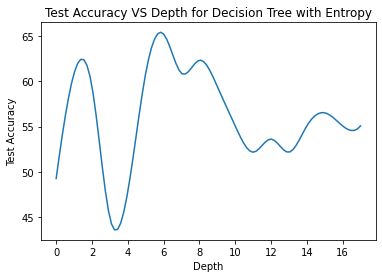

In [ ]:
from scipy.interpolate import make_interp_spline

x = []
y = []
points = []

for e in entropy_data:
    x.append(e[0])
    y.append(e[2])
    if e[0]%2 == 0:
        points.append(e[0])

x = np.array(x)
y = np.array(y)

spline = make_interp_spline(x, y)
 
depth = np.linspace(x.min(), x.max(), 100)
test_acc = spline(depth)

plt.xticks(ticks=points)

plt.title("Test Accuracy VS Depth for Decision Tree with Entropy")
plt.xlabel("Depth")
plt.ylabel("Test Accuracy")
 
# Plotting the Graph
plt.plot(depth, test_acc)
plt.show()

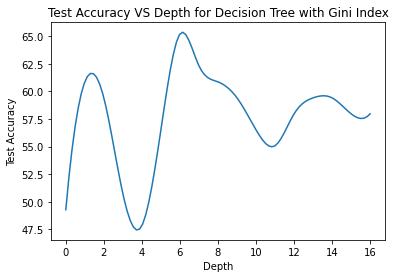

In [ ]:
from scipy.interpolate import make_interp_spline

x = []
y = []
points = []

for e in gini_index_data:
    x.append(e[0])
    y.append(e[2])
    if e[0]%2 == 0:
        points.append(e[0])

x = np.array(x)
y = np.array(y)

spline = make_interp_spline(x, y)
 
depth = np.linspace(x.min(), x.max(), 100)
test_acc = spline(depth)

plt.xticks(ticks=points)

plt.title("Test Accuracy VS Depth for Decision Tree with Gini Index")
plt.xlabel("Depth")
plt.ylabel("Test Accuracy")
 
# Plotting the Graph
plt.plot(depth, test_acc)
plt.show()

### **Plotting of Test Accuracy VS Total number of Nodes in Decision Tree**

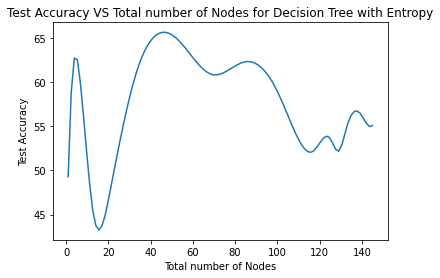

In [ ]:
from scipy.interpolate import make_interp_spline

x = []
y = []

for e in entropy_data:
    x.append(e[1])
    y.append(e[2])

x = np.array(x)
y = np.array(y)

spline = make_interp_spline(x, y)
 
depth = np.linspace(x.min(), x.max(), 100)
test_acc = spline(depth)

plt.title("Test Accuracy VS Total number of Nodes for Decision Tree with Entropy")
plt.xlabel("Total number of Nodes")
plt.ylabel("Test Accuracy")
 
# Plotting the Graph
plt.plot(depth, test_acc)
plt.show()

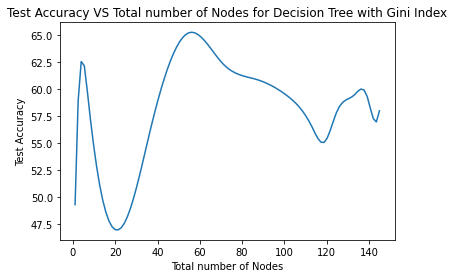

In [ ]:
from scipy.interpolate import make_interp_spline

x = []
y = []

for e in gini_index_data:
    x.append(e[1])
    y.append(e[2])

x = np.array(x)
y = np.array(y)

spline = make_interp_spline(x, y)
 
depth = np.linspace(x.min(), x.max(), 100)
test_acc = spline(depth)

plt.title("Test Accuracy VS Total number of Nodes for Decision Tree with Gini Index")
plt.xlabel("Total number of Nodes")
plt.ylabel("Test Accuracy")
 
# Plotting the Graph
plt.plot(depth, test_acc)
plt.show()

## **4. Perform the pruning operation over the tree with the highest test accuracy (Decision Tree with Gini Index has higher test accuracy in our case) in question 2 using a valid statistical test for comparison.**

### **We first look at the accuracy provided by the Decision Tree with Gini Index Impurity Measure without pruning on the test data.**

In [ ]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

model_gini_index = DecisionTree(impurity_measure="gini_index")
model_gini_index.fit(X_train, y_train)

correct = 0

for i in range(len(X_train)):
  prediction = model_gini_index.predict(X_train.iloc[i])
  if prediction == y_train.iloc[i]:
    correct += 1

print("Train Accuracy of Decision Tree with Gini Index:", (correct/len(X_train))*100)

correct = 0

for i in range(len(X_test)):
  prediction = model_gini_index.predict(X_test.iloc[i])
  if prediction == y_test.iloc[i]:
    correct += 1

print("Test Accuracy of Decision Tree with Gini Index:", (correct/len(X_test))*100)

Train Accuracy of Decision Tree with Gini Index: 100.0
Test Accuracy of Decision Tree with Gini Index: 57.971014492753625


### **Function to Print a Decision Tree**


In [ ]:
def print_tree(root, depth=0):
    for _ in range(depth):
        print("|   ", end='')
    print("|--- ", end='')

    if root.is_leaf:
        print("class:", root.target_class)
    else:
        print(root.attribute, "<=", root.split_value)
        print_tree(root.left, depth+1)

        for _ in range(depth):
            print("|   ", end='')
        print("|--- ", end='')
        
        print(root.attribute, ">", root.split_value)
        print_tree(root.right, depth+1)

### **Print the Decision Tree with Gini Index Impurity Measure before Pruning**

In [ ]:
print_tree(model_gini_index.root)

|--- gammagt <= 43
|   |--- sgpt <= 45
|   |   |--- sgpt <= 22
|   |   |   |--- mcv <= 93
|   |   |   |   |--- gammagt <= 19
|   |   |   |   |   |--- alkphos <= 51
|   |   |   |   |   |   |--- mcv <= 81
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- mcv > 81
|   |   |   |   |   |   |   |--- gammagt <= 18
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- gammagt > 18
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- alkphos > 51
|   |   |   |   |   |   |--- gammagt <= 9
|   |   |   |   |   |   |   |--- alkphos <= 104
|   |   |   |   |   |   |   |   |--- sgot <= 11
|   |   |   |   |   |   |   |   |   |--- mcv <= 88
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- mcv > 88
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- sgot > 11
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- alkphos > 104
|  

### **Performing Post Pruning on Decision Tree with Gini Index Impurity Measure as it provided higher test accuracy than the Decision Tree with Entropy. We used Chi-squared test for Pruning the Decision Tree. The threshold for the Chi-square test is set to 4 after experimentations as 4 was providing a descent improvement in test accuracy.**

In [ ]:
def post_pruning(root, data):
    if root.is_leaf:
        return root
    
    epsilon = 4                         # set cutoff for gain as 4. epsilon cutoff of 4 is found to provide good improvement in test accuracy.

    left_data = data[data[root.attribute] <= root.split_value]
    right_data = data[data[root.attribute] > root.split_value]
    
    root.left = post_pruning(root.left, left_data)
    root.right = post_pruning(root.right, right_data)

    k = 0

    target = data.columns[-1]
    classes = data[target].unique()

    left_proportion = len(left_data)/len(data)
    right_proportion = len(right_data)/len(data)

    for c in classes:
        count = len(data[data[target] == c])
        count_left = len(left_data[left_data[target] == c])
        count_right = len(right_data[right_data[target] == c])

        k += ((count*left_proportion - count_left)**2)/(count*left_proportion)
        k += ((count*right_proportion - count_right)**2)/(count*right_proportion)

    if k < epsilon:
        majority = 0
        majority_class = None

        for c in classes:
            count = len(data[data[target] == c])
            if count > majority:
                majority = count
                majority_class = c

        return TreeNode(is_leaf=True, target_class=majority_class)

    return root


data = pd.concat([X_train, y_train], axis=1)

model_gini_index.root = post_pruning(model_gini_index.root, data)

correct = 0

for i in range(len(X_train)):
    prediction = model_gini_index.predict(X_train.iloc[i])
    if prediction == y_train.iloc[i]:
        correct += 1

print(f"Train Accuracy of Decision Tree with Gini Index after Pruning:", (correct/len(X_train))*100)

correct = 0

for i in range(len(X_test)):
    prediction = model_gini_index.predict(X_test.iloc[i])
    if prediction == y_test.iloc[i]:
        correct += 1

print(f"Test Accuracy of Decision Tree with Gini Index after Pruning:", (correct/len(X_test))*100)

Train Accuracy of Decision Tree with Gini Index after Pruning: 79.77941176470588
Test Accuracy of Decision Tree with Gini Index after Pruning: 66.66666666666666


### **Print the Decision Tree with Gini Index Impurity Measure after Pruning**

In [ ]:
print_tree(model_gini_index.root)

|--- gammagt <= 43
|   |--- sgpt <= 45
|   |   |--- sgpt <= 22
|   |   |   |--- mcv <= 93
|   |   |   |   |--- gammagt <= 19
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- gammagt > 19
|   |   |   |   |   |--- sgot <= 19
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- sgot > 19
|   |   |   |   |   |   |--- gammagt <= 35
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- gammagt > 35
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |--- mcv > 93
|   |   |   |   |--- class: 0
|   |   |--- sgpt > 22
|   |   |   |--- gammagt <= 13
|   |   |   |   |--- class: 0
|   |   |   |--- gammagt > 13
|   |   |   |   |--- mcv <= 86
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- mcv > 86
|   |   |   |   |   |--- sgot <= 21
|   |   |   |   |   |   |--- sgpt <= 27
|   |   |   |   |   |   |   |--- alkphos <= 69
|   |   |   |   |   |   |   |   |--- gammagt <= 30
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- gam

## **5. Print the final decision tree obtained from question 3 following the hierarchical levels of data attributes as nodes of the tree.**

### **Function to Print a Decision Tree**

In [ ]:
def print_tree(root, depth=0):
    for _ in range(depth):
        print("|   ", end='')
    print("|--- ", end='')

    if root.is_leaf:
        print("class:", root.target_class)
    else:
        print(root.attribute, "<=", root.split_value)
        print_tree(root.left, depth+1)

        for _ in range(depth):
            print("|   ", end='')
        print("|--- ", end='')
        
        print(root.attribute, ">", root.split_value)
        print_tree(root.right, depth+1)

### **Print the Best Depth Decision Tree with Entropy Impurity Measure**

In [ ]:
entropy_best_depth = 0
entropy_best_accuracy = 0

for e in entropy_data:
    if e[2] > entropy_best_accuracy:
        entropy_best_accuracy = e[2]
        entropy_best_depth = e[0]

print("Best depth of Decision Tree with Entropy Impurity Measure:", entropy_best_depth)
print()

model_entropy = DecisionTree(impurity_measure="entropy", max_depth=entropy_best_depth)
model_entropy.fit(X_train, y_train)

print_tree(model_entropy.root)

Best depth of Decision Tree with Entropy Impurity Measure: 6

|--- gammagt <= 43
|   |--- sgpt <= 45
|   |   |--- sgpt <= 22
|   |   |   |--- mcv <= 93
|   |   |   |   |--- gammagt <= 19
|   |   |   |   |   |--- alkphos <= 51
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- alkphos > 51
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- gammagt > 19
|   |   |   |   |   |--- sgpt <= 17
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- sgpt > 17
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- mcv > 93
|   |   |   |   |--- alkphos <= 60
|   |   |   |   |   |--- gammagt <= 16
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- gammagt > 16
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- alkphos > 60
|   |   |   |   |   |--- class: 0
|   |   |--- sgpt > 22
|   |   |   |--- gammagt <= 13
|   |   |   |   |--- class: 0
|   |   |   |--- gammagt > 13
|   |   |   |   |--- mcv <= 86
|   |   |   |   |   |--- sgot <= 22
|   |   |   |   

### **Print the Best Depth Decision Tree with Gini Index Impurity Measure**

In [ ]:
gini_index_best_depth = 0
gini_index_best_accuracy = 0

for e in gini_index_data:
    if e[2] > gini_index_best_accuracy:
        gini_index_best_accuracy = e[2]
        gini_index_best_depth = e[0]

print("Best depth of Decision Tree with Gini Index Impurity Measure:", gini_index_best_depth)

model_gini_index = DecisionTree(impurity_measure="gini_index", max_depth=gini_index_best_depth)
model_gini_index.fit(X_train, y_train)

print_tree(model_gini_index.root)

Best depth of Decision Tree with Gini Index Impurity Measure: 6
|--- gammagt <= 43
|   |--- sgpt <= 45
|   |   |--- sgpt <= 22
|   |   |   |--- mcv <= 93
|   |   |   |   |--- gammagt <= 19
|   |   |   |   |   |--- alkphos <= 51
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- alkphos > 51
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- gammagt > 19
|   |   |   |   |   |--- sgot <= 19
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- sgot > 19
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- mcv > 93
|   |   |   |   |--- alkphos <= 60
|   |   |   |   |   |--- gammagt <= 16
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- gammagt > 16
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- alkphos > 60
|   |   |   |   |   |--- class: 0
|   |   |--- sgpt > 22
|   |   |   |--- gammagt <= 13
|   |   |   |   |--- class: 0
|   |   |   |--- gammagt > 13
|   |   |   |   |--- mcv <= 86
|   |   |   |   |   |--- sgot <= 22
|   |   |   | 

### **Report Train Accuracy VS Test Accuracy VS Total Number of Nodes VS Depth of Tree**

In [ ]:
def accuracy_vs_depth(train, test, max_depth):
    X_train = train.iloc[:, :-1]
    y_train = train.iloc[:, -1]

    X_test = test.iloc[:, :-1]
    y_test = test.iloc[:, -1]

    entropy_train_data = []
    entropy_test_data = []
    gini_index_train_data = []
    gini_index_test_data = []

    for depth in range(max_depth+1):
        model_entropy = DecisionTree(impurity_measure="entropy", max_depth=depth)
        model_entropy.fit(X_train, y_train)

        correct_entropy = 0

        for j in range(len(X_train)):
            prediction = model_entropy.predict(X_train.iloc[j])
            if prediction == y_train.iloc[j]:
                correct_entropy += 1

        accuracy_entropy = (correct_entropy/len(X_train))*100
        if len(entropy_train_data) == 0 or model_entropy.tree_depth() > entropy_train_data[-1][0]:
            entropy_train_data.append([model_entropy.tree_depth(), model_entropy.tree_nodes(), accuracy_entropy])

        correct_entropy = 0

        for j in range(len(X_test)):
            prediction = model_entropy.predict(X_test.iloc[j])
            if prediction == y_test.iloc[j]:
                correct_entropy += 1

        accuracy_entropy = (correct_entropy/len(X_test))*100
        if len(entropy_test_data) == 0 or model_entropy.tree_depth() > entropy_test_data[-1][0]:
            entropy_test_data.append([model_entropy.tree_depth(), model_entropy.tree_nodes(), accuracy_entropy])

        model_gini_index = DecisionTree(impurity_measure="gini_index", max_depth=depth)
        model_gini_index.fit(X_train, y_train)

        correct_gini_index = 0

        for j in range(len(X_train)):
            prediction = model_gini_index.predict(X_train.iloc[j])
            if prediction == y_train.iloc[j]:
                correct_gini_index += 1

        accuracy_gini_index = (correct_gini_index/len(X_train))*100
        if len(gini_index_train_data) == 0 or model_gini_index.tree_depth() > gini_index_train_data[-1][0]:
            gini_index_train_data.append([model_gini_index.tree_depth(), model_gini_index.tree_nodes(), accuracy_gini_index])

        correct_gini_index = 0

        for j in range(len(X_test)):
            prediction = model_gini_index.predict(X_test.iloc[j])
            if prediction == y_test.iloc[j]:
                correct_gini_index += 1

        accuracy_gini_index = (correct_gini_index/len(X_test))*100
        if len(gini_index_test_data) == 0 or model_gini_index.tree_depth() > gini_index_test_data[-1][0]:
            gini_index_test_data.append([model_gini_index.tree_depth(), model_gini_index.tree_nodes(), accuracy_gini_index])

    print("Details of depth VS number of nodes VS train accuracy for Decision Tree with Entropy Impurity Measure")
    for e in entropy_train_data:
        print(f"Depth: {e[0]}\t Nodes: {e[1]}\t Accuracy: {e[2]}")

    print("\n-----------------------------------------------------------------------------------------------------\n")

    print("Details of depth VS number of nodes VS test accuracy for Decision Tree with Entropy Impurity Measure")
    for e in entropy_test_data:
        print(f"Depth: {e[0]}\t Nodes: {e[1]}\t Accuracy: {e[2]}")

    print("\n-----------------------------------------------------------------------------------------------------\n")

    print("Details of depth VS number of nodes VS train accuracy for Decision Tree with Gini Index Impurity Measure")
    for e in gini_index_train_data:
        print(f"Depth: {e[0]}\t Nodes: {e[1]}\t Accuracy: {e[2]}")

    print("\n-----------------------------------------------------------------------------------------------------\n")

    print("Details of depth VS number of nodes VS test accuracy for Decision Tree with Gini Index Impurity Measure")
    for e in gini_index_test_data:
        print(f"Depth: {e[0]}\t Nodes: {e[1]}\t Accuracy: {e[2]}")

    return (entropy_train_data, entropy_test_data, gini_index_train_data, gini_index_test_data)


max_depth = max(model_entropy.tree_depth(), model_gini_index.tree_depth())

entropy_train_data, entropy_test_data, gini_index_train_data, gini_index_test_data = accuracy_vs_depth(train, test, max_depth)

Details of depth VS number of nodes VS train accuracy for Decision Tree with Entropy Impurity Measure
Depth: 0	 Nodes: 1	 Accuracy: 51.10294117647059
Depth: 1	 Nodes: 3	 Accuracy: 60.66176470588235
Depth: 2	 Nodes: 7	 Accuracy: 62.5
Depth: 3	 Nodes: 13	 Accuracy: 64.33823529411765
Depth: 4	 Nodes: 21	 Accuracy: 70.22058823529412
Depth: 5	 Nodes: 33	 Accuracy: 71.32352941176471
Depth: 6	 Nodes: 51	 Accuracy: 77.94117647058823
Depth: 7	 Nodes: 69	 Accuracy: 83.45588235294117
Depth: 8	 Nodes: 85	 Accuracy: 85.66176470588235
Depth: 9	 Nodes: 99	 Accuracy: 88.97058823529412
Depth: 10	 Nodes: 107	 Accuracy: 91.54411764705883
Depth: 11	 Nodes: 117	 Accuracy: 93.38235294117648
Depth: 12	 Nodes: 125	 Accuracy: 94.48529411764706
Depth: 13	 Nodes: 129	 Accuracy: 95.22058823529412
Depth: 14	 Nodes: 133	 Accuracy: 97.42647058823529
Depth: 15	 Nodes: 139	 Accuracy: 98.52941176470588
Depth: 16	 Nodes: 143	 Accuracy: 99.63235294117648
Depth: 17	 Nodes: 145	 Accuracy: 100.0

---------------------------

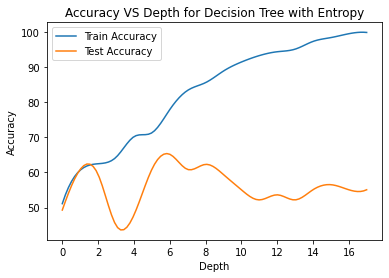

In [ ]:
from scipy.interpolate import make_interp_spline

x = []
y_train = []
y_test = []
points = []

for e in entropy_train_data:
    x.append(e[0])
    y_train.append(e[2])
    if e[0]%2 == 0:
        points.append(e[0])

for e in entropy_test_data:
    y_test.append(e[2])

x = np.array(x)
y_train = np.array(y_train)
y_test = np.array(y_test)

spline_train = make_interp_spline(x, y_train)
spline_test = make_interp_spline(x, y_test)

depth = np.linspace(x.min(), x.max(), 100)
train_acc = spline_train(depth)
test_acc = spline_test(depth)

plt.xticks(ticks=points)

plt.title("Accuracy VS Depth for Decision Tree with Entropy")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
 
# Plotting the Graph
plt.plot(depth, train_acc, label="Train Accuracy")
plt.plot(depth, test_acc, label="Test Accuracy")

plt.legend()

plt.show()

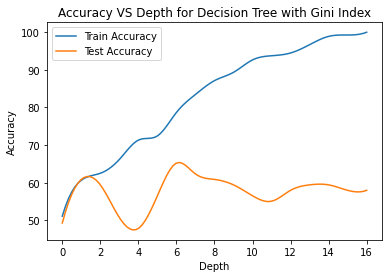

In [ ]:
from scipy.interpolate import make_interp_spline

x = []
y_train = []
y_test = []
points = []

for e in gini_index_train_data:
    x.append(e[0])
    y_train.append(e[2])
    if e[0]%2 == 0:
        points.append(e[0])

for e in gini_index_test_data:
    y_test.append(e[2])

x = np.array(x)
y_train = np.array(y_train)
y_test = np.array(y_test)

spline_train = make_interp_spline(x, y_train)
spline_test = make_interp_spline(x, y_test)

depth = np.linspace(x.min(), x.max(), 100)
train_acc = spline_train(depth)
test_acc = spline_test(depth)

plt.xticks(ticks=points)

plt.title("Accuracy VS Depth for Decision Tree with Gini Index")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
 
# Plotting the Graph
plt.plot(depth, train_acc, label="Train Accuracy")
plt.plot(depth, test_acc, label="Test Accuracy")

plt.legend()

plt.show()

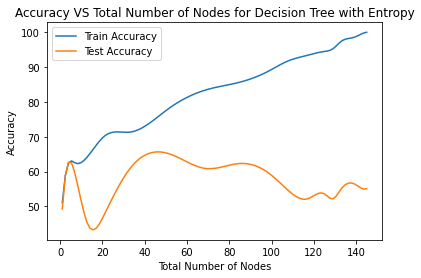

In [ ]:
from scipy.interpolate import make_interp_spline

x = []
y_train = []
y_test = []

for e in entropy_train_data:
    x.append(e[1])
    y_train.append(e[2])

for e in entropy_test_data:
    y_test.append(e[2])

x = np.array(x)
y_train = np.array(y_train)
y_test = np.array(y_test)

spline_train = make_interp_spline(x, y_train)
spline_test = make_interp_spline(x, y_test)

nodes = np.linspace(x.min(), x.max(), 100)
train_acc = spline_train(nodes)
test_acc = spline_test(nodes)

plt.title("Accuracy VS Total Number of Nodes for Decision Tree with Entropy")
plt.xlabel("Total Number of Nodes")
plt.ylabel("Accuracy")
 
# Plotting the Graph
plt.plot(nodes, train_acc, label="Train Accuracy")
plt.plot(nodes, test_acc, label="Test Accuracy")

plt.legend()

plt.show()

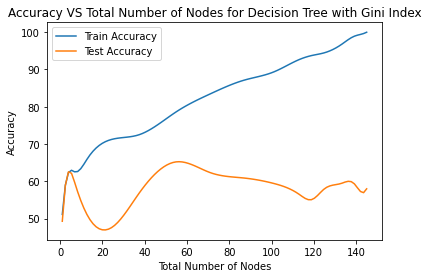

In [ ]:
from scipy.interpolate import make_interp_spline

x = []
y_train = []
y_test = []

for e in gini_index_train_data:
    x.append(e[1])
    y_train.append(e[2])

for e in gini_index_test_data:
    y_test.append(e[2])

x = np.array(x)
y_train = np.array(y_train)
y_test = np.array(y_test)

spline_train = make_interp_spline(x, y_train)
spline_test = make_interp_spline(x, y_test)

nodes = np.linspace(x.min(), x.max(), 100)
train_acc = spline_train(nodes)
test_acc = spline_test(nodes)

plt.title("Accuracy VS Total Number of Nodes for Decision Tree with Gini Index")
plt.xlabel("Total Number of Nodes")
plt.ylabel("Accuracy")
 
# Plotting the Graph
plt.plot(nodes, train_acc, label="Train Accuracy")
plt.plot(nodes, test_acc, label="Test Accuracy")

plt.legend()

plt.show()